In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams['figure.figsize'] = 16, 12
import pandas as pd
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold
import seaborn as sns
sns.set_style("dark")

In [2]:
# read data
data = {}
is_first_line = True
with open('./../data/raw/train.csv', 'r') as f: 
    for line in f:
        if is_first_line:
            is_first_line = False
            continue
        parts = line.strip().split(',')
        data[int(parts[0])] = pd.DataFrame(np.array(map(int, parts[1].strip().split(' '))), columns=['nday'])
        
#add week day column 
def nday_to_weekday(v):
    v = np.remainder(v, 7)
    v[v == 0] = 7
    return v

for key in data:
    data[key]['weekday'] = nday_to_weekday(data[key]['nday'])
    data[key]['gap'] = \
        data[key]['nday'].values - np.hstack((data[key]['nday'].values[0], data[key]['nday'].values[:-1]))

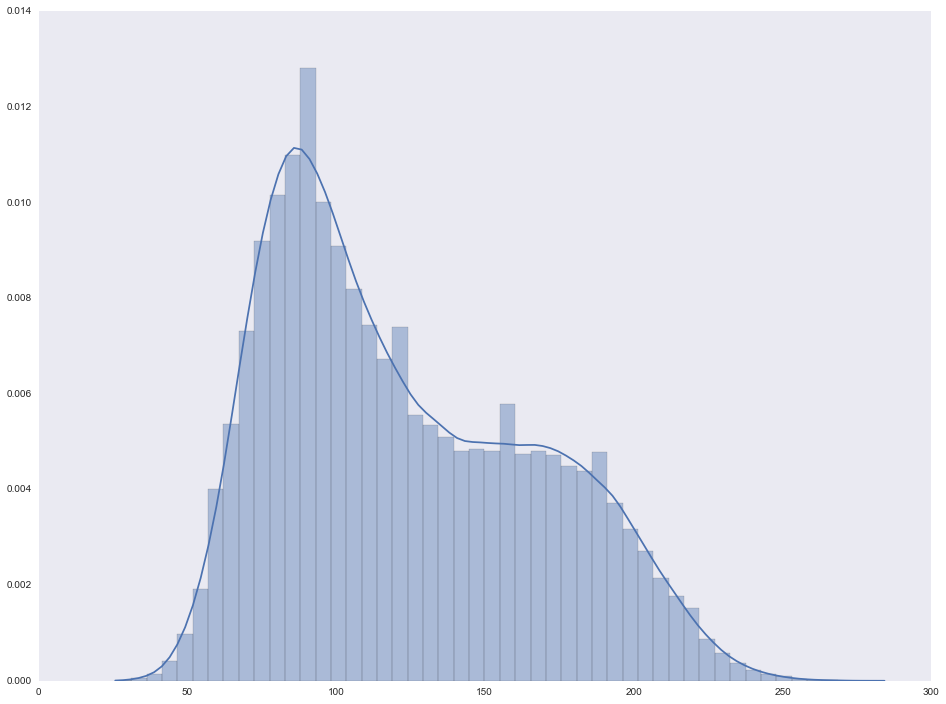

In [48]:
# visits frequency
mat_visits = np.zeros((len(data), 1100))
for k in data.keys():
    mat_visits[k - 1, data[k]['nday'].values] = 1

visit_freq = mat_visits.sum(axis=1)/1099.0

sns.distplot(mat_visits.sum(axis=1))

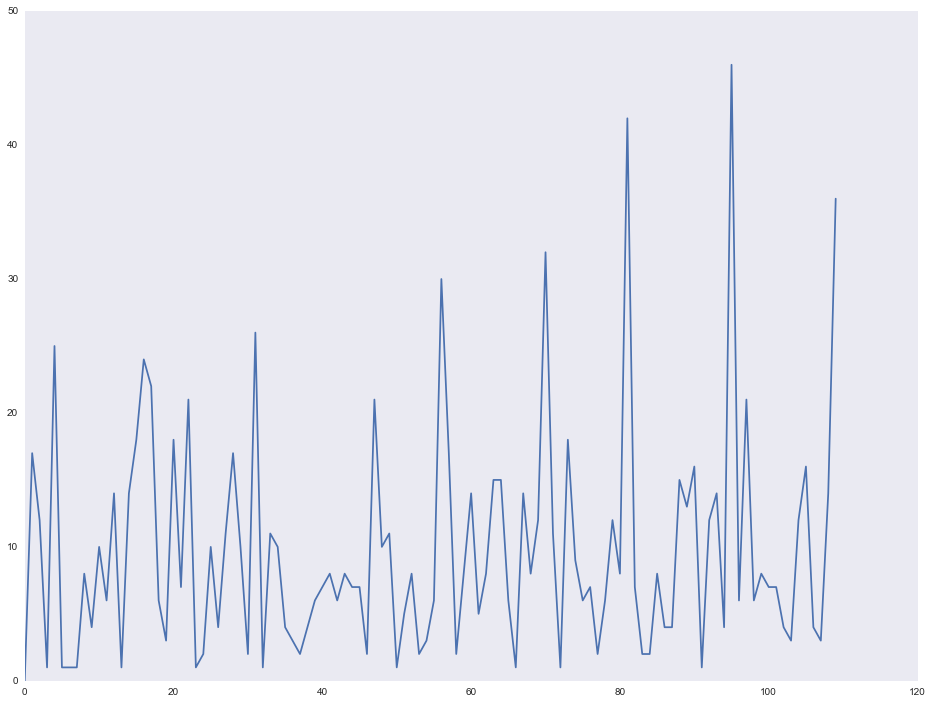

In [49]:
# typical gap dynamics between visits
plt.plot(data[128000]['gap'])

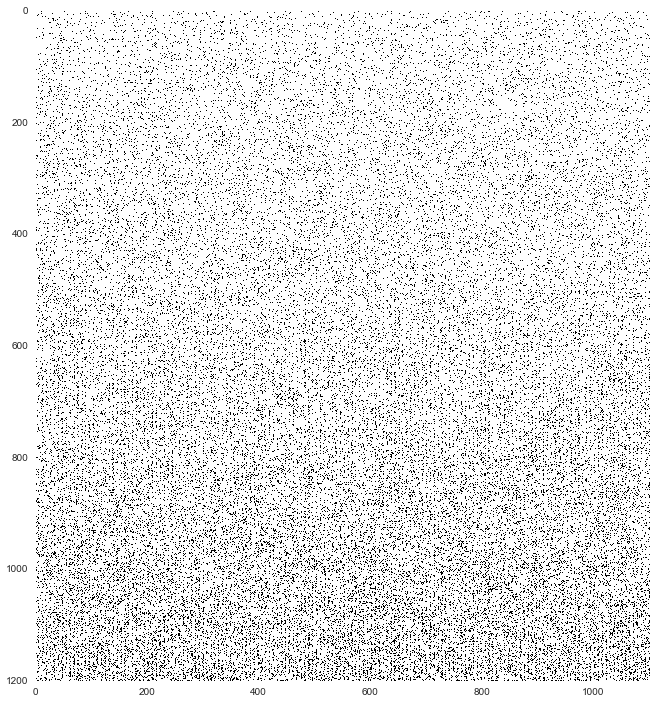

In [50]:
# density of visits: each line is users visits (sampled each 250th user)
plt.imshow(mat_visits[np.arange(0, mat_visits.shape[0], 250), :], interpolation='nearest')
plt.show()

In [6]:
# some useful functions

# save submit in correct format (with space)
def save_submit(name, ids, pred):
    with open(name, 'w') as f:
        f.write('id,nextvisit\n')
        for t in zip(ids, pred):
            f.write('%i, %i\n' % t)
            
# vector of visits to week X day matrix, can skip empty weeks
def visits_to_weekmatrix(v, skip_empty_weeks=True, d_max=1099):
    u = np.zeros(d_max)
    u[v - 1] = 1
    if not skip_empty_weeks: 
        return u.reshape((d_max/7, 7))
    m = u.reshape((d_max/7, 7))
    return m[m.sum(axis=1) > 0, :]

# distribution of visits ovew weeks
def weekvisit_distr(m):
    d = m.sum(axis=0)
    return d/d.sum()

# distribution of first visited day of weeks using recalculation
def firstweekvisit_distr(m):
    d = weekvisit_distr(m)
    return d*np.hstack((1, np.cumprod((1 - d))[:-1]))


# vector of visits to week X day matrix, where each line contains one at the day when first visit was done
def visits_to_firstvisitweekmatrix(v, skip_empty_weeks=True):
    m = visits_to_weekmatrix(v, skip_empty_weeks)
    mi = np.array([t for t in 
                   map(lambda i: (i, np.where(m[i, :] > 0)[0][0] if m[i, :].sum() > 0 else -1), 
                       range(m.shape[0])) 
                   if t[1] > -1])
    f = np.zeros(m.shape)
    f[mi[:, 0], mi[:, 1]] = 1
    return f

def visitsmatrix_to_firstvisitweekmatrix(m):
    i = np.apply_along_axis(lambda v: np.where(v > 0)[0][0] if v.sum() > 0 else 0, 1, m)
    f = np.zeros(m.shape)
    f[np.where(i > 0), i[i > 0]] = 1
    return f

In [7]:
# calculate visit matrices for each data row
vmats = {}
for key in data:
    vmats[key] = {
        'visits_skiped': visits_to_weekmatrix(data[key]['nday'].values),
        'firstvisits_skiped': visits_to_firstvisitweekmatrix(data[key]['nday'].values),
        'visits': visits_to_weekmatrix(data[key]['nday'].values, skip_empty_weeks=False),
        'firstvisits': visits_to_firstvisitweekmatrix(data[key]['nday'].values, skip_empty_weeks=False)        
    }

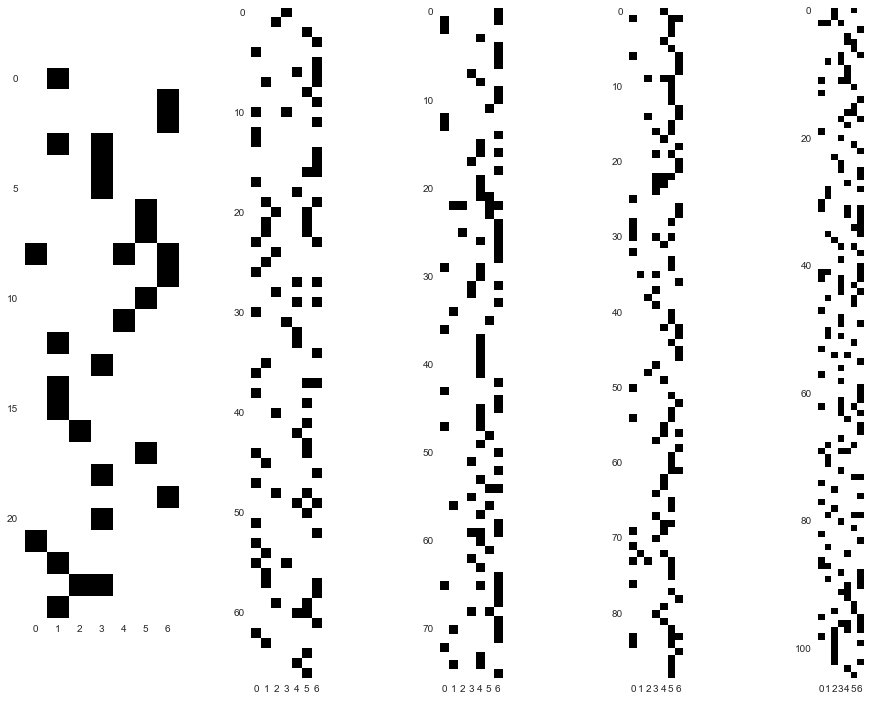

In [51]:
# plot of week visits of five users 

fig = plt.figure() 
gs = gridspec.GridSpec(1, 5)
keys = [1, 60000, 120000, 180000, 240000]
for i in range(5):
    ax = plt.subplot(gs[0, i])
    ax.imshow(vmats[keys[i]]['visits_skiped'], interpolation='nearest')

# ax = plt.subplot(gs[0, 0])
# ax.imshow(vmats[1]['firstvisits'], interpolation='nearest')

plt.show()

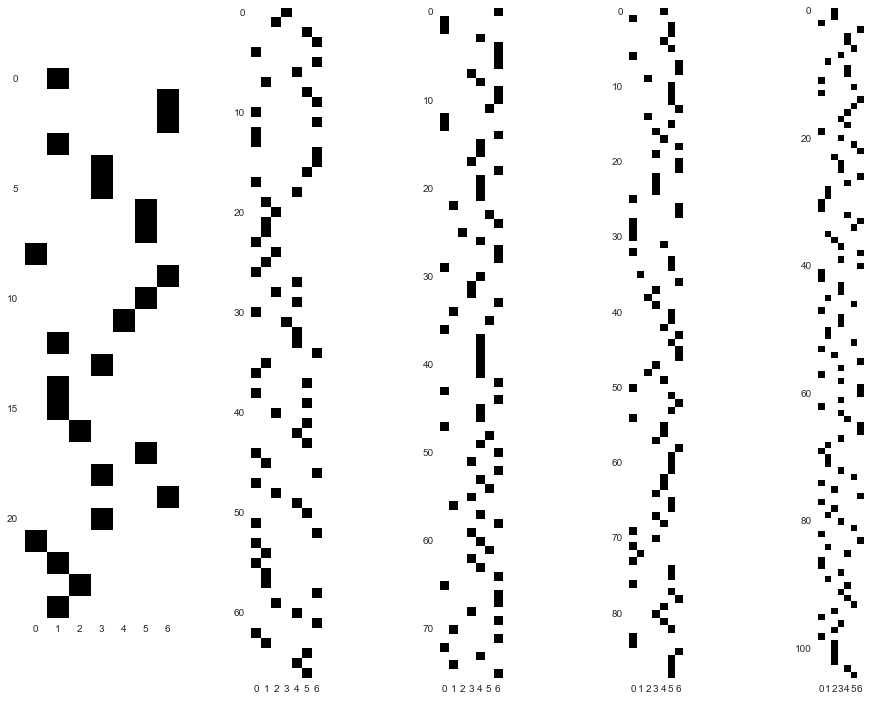

In [52]:
# plot of first week visits of five users 

fig = plt.figure() 
gs = gridspec.GridSpec(1, 5)
keys = [1, 60000, 120000, 180000, 240000]
for i in range(5):
    ax = plt.subplot(gs[0, i])
    ax.imshow(vmats[keys[i]]['firstvisits_skiped'], interpolation='nearest')

# ax = plt.subplot(gs[0, 0])
# ax.imshow(vmats[1]['firstvisits'], interpolation='nearest')

plt.show()

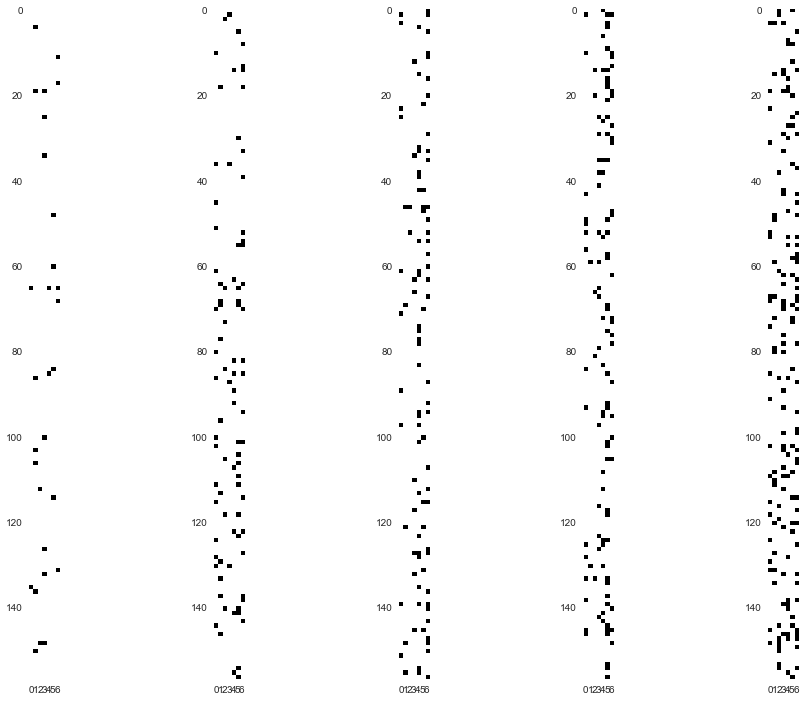

In [53]:
# plot of week visits of five users 

fig = plt.figure() 
gs = gridspec.GridSpec(1, 5)
keys = [1, 60000, 120000, 180000, 240000]
for i in range(5):
    ax = plt.subplot(gs[0, i])
    ax.imshow(vmats[keys[i]]['visits'], interpolation='nearest')

# ax = plt.subplot(gs[0, 0])
# ax.imshow(vmats[1]['firstvisits'], interpolation='nearest')

plt.show()

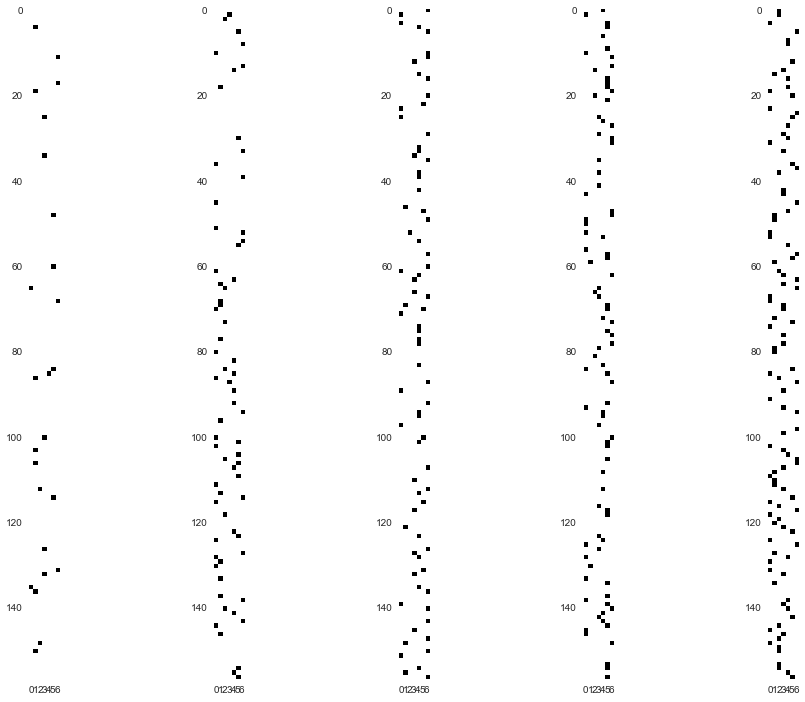

In [54]:
# plot of first week visits of five users 

fig = plt.figure() 
gs = gridspec.GridSpec(1, 5)
keys = [1, 60000, 120000, 180000, 240000]
for i in range(5):
    ax = plt.subplot(gs[0, i])
    ax.imshow(vmats[keys[i]]['firstvisits'], interpolation='nearest')

# ax = plt.subplot(gs[0, 0])
# ax.imshow(vmats[1]['firstvisits'], interpolation='nearest')

plt.show()

In [12]:
# for validation will be used FIRST day of LAST week with visit, because 1099/7 is 157, 
# so we are to predict first visited day at 158th week
vmats_valid = {}
y_valid = {}
for key in data.keys():
    v = data[key]['nday'].values
    m = visits_to_weekmatrix(v, skip_empty_weeks=False)
    week_visits = m.sum(axis=1)
    last_visited_week = np.where(week_visits > 0)[0][-1]
    t = np.where(m[last_visited_week, :] > 0)[0][0] + 1
    u = np.where(m[:last_visited_week, :].flatten() > 0)[0] + 1

    vmats_valid[key] = {
        'visits_skiped': visits_to_weekmatrix(u),
        'firstvisits_skiped': visits_to_firstvisitweekmatrix(u),
        'visits': visits_to_weekmatrix(u, skip_empty_weeks=False),
        'firstvisits': visits_to_firstvisitweekmatrix(u, skip_empty_weeks=False)        
    }
    
    y_valid[key] = t

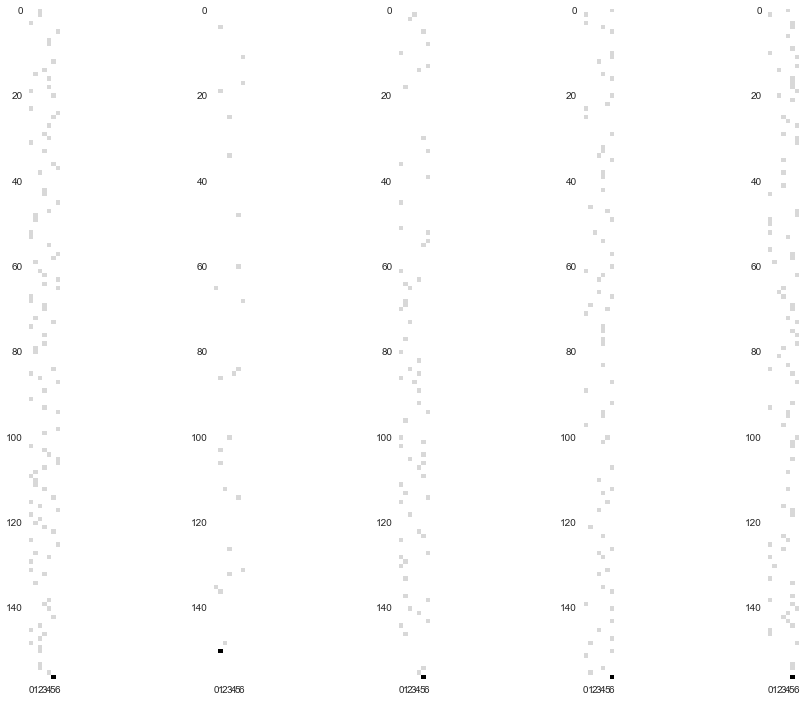

In [55]:
# examples of validation data, black dot is the our goal

fig = plt.figure() 
gs = gridspec.GridSpec(1, 5)
keys = [1, 60000, 120000, 180000, 240000]
for i in range(5):
    m = vmats[keys[i - 1]]['firstvisits'] + \
            3*(vmats[keys[i - 1]]['firstvisits'] - vmats_valid[keys[i - 1]]['firstvisits'])
    ax = plt.subplot(gs[0, i])
    ax.imshow(m, interpolation='nearest')

plt.show()

In [14]:
# results of the first level models
first_lvl = {}
valid_lb = {}

In [15]:
def search_train_predict(a_grid, f_predict):
    best_a = None
    best_score = -1
    for a in a_grid:
        wins = 0
        for key in vmats_valid.keys():
            y = f_predict(key, vmats_valid, a)
            wins += 1 if (y.argmax() + 1) == y_valid[key] else 0
        score = wins/float(len(vmats_valid))
        if score > best_score:
            best_score = score
            best_a = a
        print a, score
    
    print '---'
    print best_a, best_score

    res = dict(map(lambda key: (key, 
                                (f_predict(key, vmats_valid, best_a), 
                                 f_predict(key, vmats, best_a))), 
                   vmats_valid.keys()))
    return res

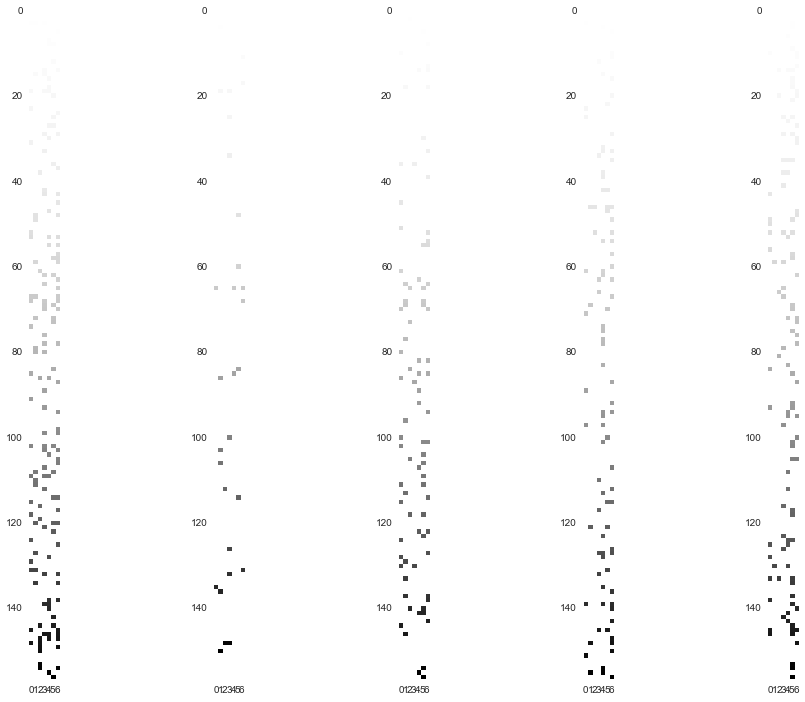

In [56]:
# let each week have its own weight

fig = plt.figure() 
gs = gridspec.GridSpec(1, 5)
keys = [1, 60000, 120000, 180000, 240000]
for i in range(5):
    m = vmats[keys[i - 1]]['visits']
    w = (np.linspace(1, m.shape[0], m.shape[0])/m.shape[0])**1.4
    w = w/w.sum()
    ax = plt.subplot(gs[0, i])
    ax.imshow((m*w.reshape((w.shape[0], 1))), interpolation='nearest')

plt.show()

first part of first layer

In [17]:
# visits week weighted model = vwwm
name = 'vwwm'
def vwwm(key, d, a):
    mat_valid = d[key]['visits']
    w = (np.linspace(1, mat_valid.shape[0], mat_valid.shape[0])/mat_valid.shape[0])**a
    w = w/w.sum()
    p = np.dot(w, mat_valid)
    return p

a_grid = np.arange(0.2, 3, 0.2)

first_lvl[name] = search_train_predict(a_grid, vwwm)

0.2 0.22506
0.4 0.226813333333
0.6 0.22827
0.8 0.229286666667
1.0 0.229446666667
1.2 0.2297
1.4 0.229883333333
1.6 0.230056666667
1.8 0.22996
2.0 0.22999
2.2 0.22999
2.4 0.229753333333
2.6 0.229316666667
2.8 0.22927
---
1.6 0.230056666667


In [18]:
save_submit('./../submits/%s.csv' % name, 
            first_lvl[name].keys(), 
            [(first_lvl[name][k][1].argmax() + 1) for k in first_lvl[name].keys()])

In [19]:
valid_lb[name] = (0.230056666667, 0.233)

In [20]:
# first visits week weighted model = fvwwm
name = 'fvwwm'
def fvwwm(key, d, a):
    mat_valid = d[key]['firstvisits']
    w = (np.linspace(1, mat_valid.shape[0], mat_valid.shape[0])/mat_valid.shape[0])**a
    w = w/w.sum()
    p = np.dot(w, mat_valid)
    return p

a_grid = np.arange(0.2, 3, 0.2)

first_lvl[name] = search_train_predict(a_grid, fvwwm)

0.2 0.237506666667
0.4 0.238793333333
0.6 0.239796666667
0.8 0.240423333333
1.0 0.240556666667
1.2 0.240786666667
1.4 0.240666666667
1.6 0.24081
1.8 0.240606666667
2.0 0.240443333333
2.2 0.23985
2.4 0.23936
2.6 0.23887
2.8 0.238366666667
---
1.6 0.24081


In [21]:
save_submit('./../submits/%s.csv' % name, 
            first_lvl[name].keys(), 
            [(first_lvl[name][k][1].argmax() + 1) for k in first_lvl[name].keys()])

In [22]:
valid_lb[name] = (0.24081, 0.24573)

In [23]:
# visits week with skipped weighted model = vwwswm
name = 'vwwswm'
def vwwswm(key, d, a):
    mat_valid = d[key]['visits_skiped']
    w = (np.linspace(1, mat_valid.shape[0], mat_valid.shape[0])/mat_valid.shape[0])**a
    w = w/w.sum()
    p = np.dot(w, mat_valid)
    return p

a_grid = np.arange(0.2, 3, 0.2)

first_lvl[name] = search_train_predict(a_grid, vwwswm)

0.2 0.224996666667
0.4 0.22657
0.6 0.228193333333
0.8 0.22897
1.0 0.229456666667
1.2 0.22955
1.4 0.229623333333
1.6 0.229863333333
1.8 0.229823333333
2.0 0.229746666667
2.2 0.229666666667
2.4 0.22955
2.6 0.229296666667
2.8 0.229073333333
---
1.6 0.229863333333


In [24]:
save_submit('./../submits/%s.csv' % name, 
            first_lvl[name].keys(), 
            [(first_lvl[name][k][1].argmax() + 1) for k in first_lvl[name].keys()])

In [25]:
valid_lb[name] = (0.229863333333, 0.23227)

In [26]:
# first visits week with skipped weighted model = fvwwswm
name = 'fvwwswm'
def fvwwswm(key, d, a):
    mat_valid = d[key]['firstvisits_skiped']
    w = (np.linspace(1, mat_valid.shape[0], mat_valid.shape[0])/mat_valid.shape[0])**a
    w = w/w.sum()
    p = np.dot(w, mat_valid)
    return p

a_grid = np.arange(0.2, 3, 0.2)

first_lvl[name] = search_train_predict(a_grid, fvwwswm)

0.2 0.23733
0.4 0.238676666667
0.6 0.23954
0.8 0.240356666667
1.0 0.240433333333
1.2 0.240656666667
1.4 0.240813333333
1.6 0.24068
1.8 0.240786666667
2.0 0.240406666667
2.2 0.23987
2.4 0.23943
2.6 0.238916666667
2.8 0.23841
---
1.4 0.240813333333


In [27]:
save_submit('./../submits/%s.csv' % name, 
            first_lvl[name].keys(), 
            [(first_lvl[name][k][1].argmax() + 1) for k in first_lvl[name].keys()])

In [28]:
valid_lb[name] = (0.240813333333, 0.24617)

second part of first layer

In [29]:
# visits week weighted model recalculation = vwwmr
name = 'vwwmr'
def vwwmr(key, d, a):
    mat_valid = d[key]['visits']
    w = (np.linspace(1, mat_valid.shape[0], mat_valid.shape[0])/mat_valid.shape[0])**a
    w = w/w.sum()
    p = firstweekvisit_distr(mat_valid*w.reshape((w.shape[0], 1)))
    return p

a_grid = np.arange(0.2, 3, 0.2)

first_lvl[name] = search_train_predict(a_grid, vwwmr)

0.2 0.236683333333
0.4 0.238636666667
0.6 0.240013333333
0.8 0.240783333333
1.0 0.24109
1.2 0.242
1.4 0.242256666667
1.6 0.242103333333
1.8 0.241733333333
2.0 0.24142
2.2 0.241243333333
2.4 0.240786666667
2.6 0.240236666667
2.8 0.24003
---
1.4 0.242256666667


In [30]:
save_submit('./../submits/%s.csv' % name, 
            first_lvl[name].keys(), 
            [(first_lvl[name][k][1].argmax() + 1) for k in first_lvl[name].keys()])

In [31]:
valid_lb[name] = (0.242256666667, 0.24490)

In [32]:
# first visits week weighted model recalculation = fvwwmr
name = 'fvwwmr'
def fvwwmr(key, d, a):
    mat_valid = d[key]['firstvisits']
    w = (np.linspace(1, mat_valid.shape[0], mat_valid.shape[0])/mat_valid.shape[0])**a
    w = w/w.sum()
    p = firstweekvisit_distr(mat_valid*w.reshape((w.shape[0], 1)))
    return p

a_grid = np.arange(0.2, 3, 0.2)

first_lvl[name] = search_train_predict(a_grid, fvwwmr)

0.2 0.22423
0.4 0.22622
0.6 0.227086666667
0.8 0.228003333333
1.0 0.22871
1.2 0.229133333333
1.4 0.22878
1.6 0.22903
1.8 0.228906666667
2.0 0.228826666667
2.2 0.22869
2.4 0.228283333333
2.6 0.228063333333
2.8 0.227803333333
---
1.2 0.229133333333


In [33]:
save_submit('./../submits/%s.csv' % name, 
            first_lvl[name].keys(), 
            [(first_lvl[name][k][1].argmax() + 1) for k in first_lvl[name].keys()])

In [34]:
valid_lb[name] = (0.229133333333, 0.23067)

In [35]:
# visits week with skipped weighted model recalculation = vwwswmr
name = 'vwwswmr'
def vwwswmr(key, d, a):
    mat_valid = d[key]['visits_skiped']
    w = (np.linspace(1, mat_valid.shape[0], mat_valid.shape[0])/mat_valid.shape[0])**a
    w = w/w.sum()
    p = firstweekvisit_distr(mat_valid*w.reshape((w.shape[0], 1)))
    return p

a_grid = np.arange(0.2, 3, 0.2)

first_lvl[name] = search_train_predict(a_grid, vwwswmr)

0.2 0.23682
0.4 0.238626666667
0.6 0.24009
0.8 0.24079
1.0 0.241143333333
1.2 0.241763333333
1.4 0.242036666667
1.6 0.2419
1.8 0.24183
2.0 0.24144
2.2 0.241206666667
2.4 0.240676666667
2.6 0.24032
2.8 0.239856666667
---
1.4 0.242036666667


In [36]:
save_submit('./../submits/%s.csv' % name, 
            first_lvl[name].keys(), 
            [(first_lvl[name][k][1].argmax() + 1) for k in first_lvl[name].keys()])

In [37]:
valid_lb[name] = (0.242036666667, 0.24537)

In [38]:
# first visits week with skipped weighted model recalculation = fvwwswmr
name = 'fvwwswmr'
def fvwwswmr(key, d, a):
    mat_valid = d[key]['firstvisits_skiped']
    w = (np.linspace(1, mat_valid.shape[0], mat_valid.shape[0])/mat_valid.shape[0])**a
    w = w/w.sum()
    p = firstweekvisit_distr(mat_valid*w.reshape((w.shape[0], 1)))
    return p

a_grid = np.arange(0.2, 3, 0.2)

first_lvl[name] = search_train_predict(a_grid, fvwwswmr)

0.2 0.22423
0.4 0.226156666667
0.6 0.227046666667
0.8 0.227776666667
1.0 0.228463333333
1.2 0.22893
1.4 0.2292
1.6 0.229223333333
1.8 0.22925
2.0 0.229086666667
2.2 0.228753333333
2.4 0.2283
2.6 0.22822
2.8 0.227653333333
---
1.8 0.22925


In [39]:
save_submit('./../submits/%s.csv' % name, 
            first_lvl[name].keys(), 
            [(first_lvl[name][k][1].argmax() + 1) for k in first_lvl[name].keys()])

In [40]:
valid_lb[name] = (0.22925, 0.23103)

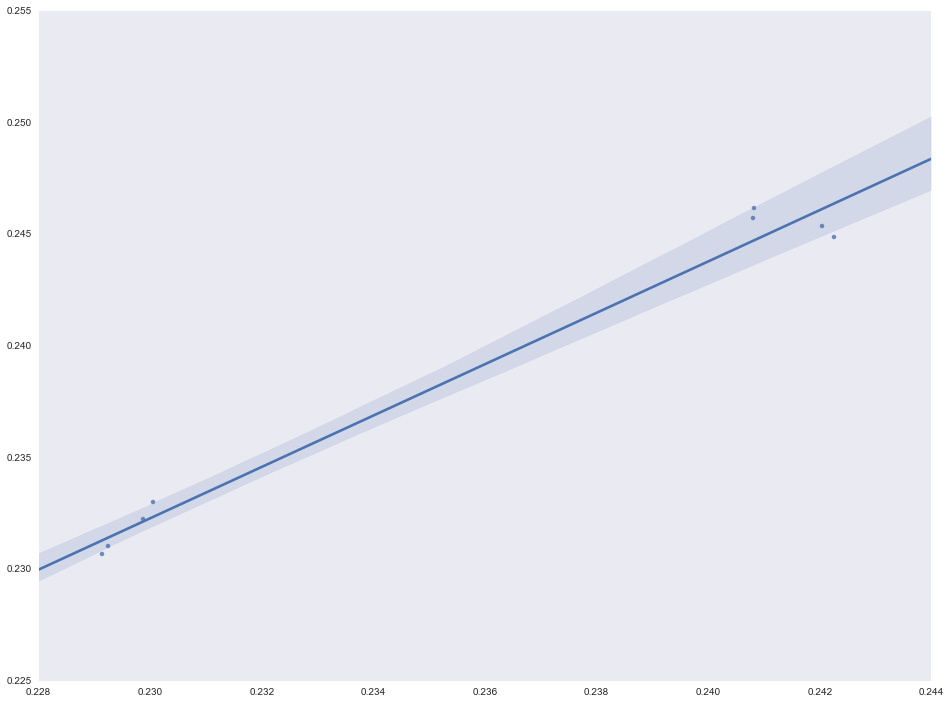

In [57]:
# check validation
# for today, I have used all submit attempt, so further I will rely only on validation score
# because as we can see that schema is highly correlated with LB one
sns.regplot(np.array(valid_lb.values())[:, 0], np.array(valid_lb.values())[:, 1])

third part of the first layer

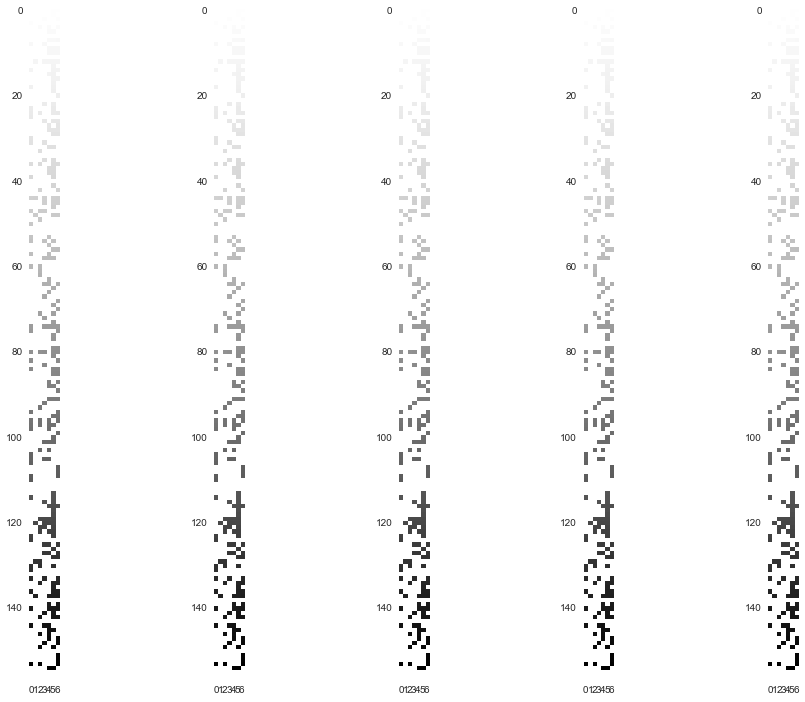

In [58]:
# let each day has its own weight

fig = plt.figure() 
gs = gridspec.GridSpec(1, 5)
keys = [1, 60000, 120000, 180000, 240000]
for i in range(5):
    mat_valid = vmats_valid[key]['visits']
    w = (np.where(mat_valid.flatten() > 0)[0]/float(np.prod(mat_valid.shape)))
    w = w/w.sum()
    m = np.zeros(np.prod(mat_valid.shape))
    m[np.where(mat_valid.flatten() > 0)[0]] = w
    m = m.reshape(mat_valid.shape)
    ax = plt.subplot(gs[0, i])
    ax.imshow(m, interpolation='nearest')

plt.show()

In [43]:
# first visits day weighted model = fvdwm
name = 'fvdwm'
def fvdwm(key, d, a):
    mat_valid = d[key]['firstvisits']
    w = (np.where(mat_valid.flatten() > 0)[0]/float(np.prod(mat_valid.shape)))**a
    w = w/w.sum()
    m = np.zeros(np.prod(mat_valid.shape))
    m[np.where(mat_valid.flatten() > 0)[0]] = w
    m = m.reshape(mat_valid.shape)
    p = m.sum(axis=0)
    p = p/p.sum()
    return p

a_grid = np.arange(0.2, 3, 0.2)

first_lvl[name] = search_train_predict(a_grid, fvdwm)

0.2 0.2374
0.4 0.23861
0.6 0.239893333333
0.8 0.240476666667
1.0 0.24067
1.2 0.24063
1.4 0.24056
1.6 0.24046
1.8 0.24043
2.0 0.24028
2.2 0.239893333333
2.4 0.239266666667
2.6 0.238483333333
2.8 0.23829
---
1.0 0.24067


In [44]:
# first visits skipped day weighted model = fvsdwm
name = 'fvsdwm'
def fvsdwm(key, d, a):
    mat_valid = d[key]['firstvisits_skiped']
    w = (np.where(mat_valid.flatten() > 0)[0]/float(np.prod(mat_valid.shape)))**a
    w = w/w.sum()
    m = np.zeros(np.prod(mat_valid.shape))
    m[np.where(mat_valid.flatten() > 0)[0]] = w
    m = m.reshape(mat_valid.shape)
    p = m.sum(axis=0)
    p = p/p.sum()
    return p

a_grid = np.arange(0.2, 3, 0.2)

first_lvl[name] = search_train_predict(a_grid, fvsdwm)

0.2 0.237313333333
0.4 0.23849
0.6 0.239443333333
0.8 0.24034
1.0 0.240623333333
1.2 0.24031
1.4 0.240413333333
1.6 0.24064
1.8 0.24036
2.0 0.239926666667
2.2 0.23939
2.4 0.239196666667
2.6 0.238646666667
2.8 0.238113333333
---
1.6 0.24064


In [45]:
# union of all predictions for new dataset for second layer

X_train = []
X_test = []
ids = np.array(data.keys())
y_train = np.array(map(lambda i: y_valid[i], ids))


for i in ids:
    v_train = []
    v_test = []
    for pred_type in first_lvl.keys():
        v_train.append(first_lvl[pred_type][i][0])
        v_test.append(first_lvl[pred_type][i][1])
    X_train.append(np.hstack(tuple(v_train)))
    X_test.append(np.hstack(tuple(v_test)))

X_train = np.array(X_train)
X_test = np.array(X_test)

In [46]:
# save data

with open('./first_lvl_bak.npz', 'wb') as f:
    np.savez(f, X_train=X_train, y_train=y_train, X_test=X_test, ids=ids)